<a href="https://colab.research.google.com/github/gabrielfers/Avaliacao-modelos-ML/blob/main/Predicao_precos_etanol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AVALIANDO MODELOS DE APRENDIZADO DE MÁQUINA NA PREVISÃO DOS PREÇOS DE ETANOL HIDRATADO EM ALAGOAS, COM BASE EM DADOS DO CEPEA - ESALQ/USP NO PERÍODO DE 2004 A 2024.**

# **1. IMPORTAÇÃO DAS BIBLIOTECAS**

In [ ]:
#importando bibliotecas mais comuns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MinMaxScaler

# **2. IMPORTAÇÃO DOS DADOS**

In [ ]:
#leitura da base de dados
precos_etanol = pd.read_csv('/content/precos_etanol_2004_2024.csv', delimiter=';')

In [ ]:
#visualizando as 5 primeiras linhas
precos_etanol.head()

,Etanol | Indicador Mensal do Etanol Hidratado Combustível CEPEA/ESALQ - Alagoas,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Nota,"Sem frete, sem ICMS\nEm junho de 2011, o númer...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fonte,Cepea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Data,À vista R$,À vista US$,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/2004,"0,5960","0,2094",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,02/2004,"0,6010","0,2056",NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.1. Formatação dos dados

In [ ]:
#apagando as 3 primeiras linhas e selecionando apenas as colunas que serão utilizadas
precos_etanol = precos_etanol.iloc[3:]
precos_etanol = precos_etanol.drop(precos_etanol.columns[3:10], axis=1)


In [ ]:
#renomeando as colunas
precos_etanol = precos_etanol.rename(columns={precos_etanol.columns[0]: 'data',
                                            precos_etanol.columns[1]: 'preco_real',
                                            precos_etanol.columns[2]: 'preco_dolar'})


In [ ]:
#transformando os tipos de dados das colunas data e preco_real
precos_etanol['data'] = pd.to_datetime(precos_etanol['data'])
precos_etanol['preco_real'] = precos_etanol['preco_real'].str.replace(',', '.').astype(float)

<ipython-input-6-77626b472a21>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  precos_etanol['data'] = pd.to_datetime(precos_etanol['data'])


In [ ]:
precos_etanol

,data,preco_real,preco_dolar
3,2004-01-01,0.5960,"0,2094"
4,2004-02-01,0.6010,"0,2056"
5,2004-03-01,0.5781,"0,1991"
6,2004-04-01,0.5520,"0,1902"
7,2004-05-01,0.5976,"0,1944"
...,...,...,...
224,2024-01-01,2.1956,"0,4474"
225,2024-02-01,2.4451,"0,4931"
226,2024-03-01,2.6086,"0,5242"
227,2024-04-01,2.7437,"0,5361"


In [ ]:
#resetando o indice
precos_etanol.reset_index(drop=True, inplace=True)

In [ ]:
#verificando o dataset
#indice inicia no 3, pois as 3 primeiras linhas foram retiradas
precos_etanol.head()

,data,preco_real,preco_dolar
0,2004-01-01,0.5960,"0,2094"
1,2004-02-01,0.6010,"0,2056"
2,2004-03-01,0.5781,"0,1991"
3,2004-04-01,0.5520,"0,1902"
4,2004-05-01,0.5976,"0,1944"


# **3. ANÁLISE DA SÉRIE TEMPORAL**

## 3.1. Métodos de Plotagem

In [ ]:
def plotar_serie(serie_temporal, datas):
  plt.plot(serie_temporal, datas)
  plt.xlabel('Ano')
  plt.ylabel('Preço em real')
  plt.title('Preço do Etanol Hidratado em Alagoas')
  plt.show()

## 3.2. Análise Visual dos Dados

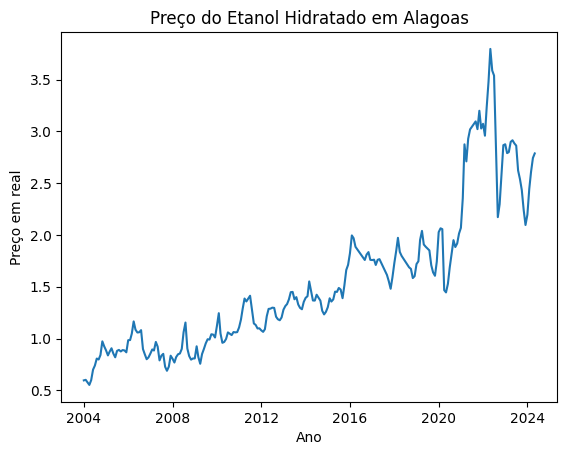

In [ ]:
#plotando a serie temporal dos precos de etanol em alagoas
plotar_serie(precos_etanol['data'], precos_etanol['preco_real'])

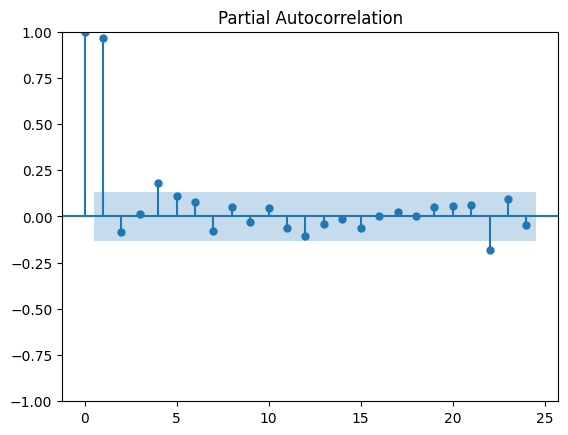

In [ ]:
#plotando o gráfico de correlação parcial
#ideal para verificar se há dependencia entre os dados e definir o tamanho do lag na janela de tempo
plot_pacf(precos_etanol['preco_real'])
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.title('Gráfico de Correlação Parcial')
plt.show()

# **4. ANÁLISE DA SÉRIE TEMPORAL**

## 4.1. Métodos de Pré-processamento

In [ ]:
#função para calcular janela de tempo
#a entrada sera a variavel independente e o lag(p)
#retorna X(padrões de entrada) e y(alvo)
def janela_de_tempo(serie_temporal, p):
  x = []
  y = []

  for i in range(len(serie_temporal)-p):
    x.append(serie_temporal[i:i+p])
    y.append(serie_temporal[i+p])

  return np.array(x).reshape(len(x), -1), np.array(y).ravel()

In [ ]:
#função para dividir os dados  de forma percentual em Treinamento, Validação e Teste
def dividir_dados(dados, porcent_trein, porcent_val, porcent_test):

    if (porcent_trein + porcent_val + porcent_test) == 1:
      total = len(dados)
      x_trein = int(total * porcent_trein)
      x_val = int(total * (porcent_trein + porcent_val))

      treinamento = dados[:x_trein]
      validacao = dados[x_trein:x_val]
      teste = dados[x_val:]

      return treinamento, validacao, teste

    else:

      print("A soma das porcentagens deve ser igual a 1")

## 4.2. Pré-processamento dos dados

In [ ]:
#normalizando os dados da coluna independente para escala de 0 a 1
#ideal para trabalhar com modelos de machine learning
scaler = MinMaxScaler()
precos_normalizados = scaler.fit_transform(precos_etanol['preco_real'].values.reshape(-1, 1))

In [ ]:
#aplicando a janela de tempo com lag 2
X, y = janela_de_tempo(precos_normalizados, 2)

In [ ]:
#Aplicando a função dividir_dados para divdir em 80% Treinamento e 20% Teste
treinamento_X, validação_X, teste_X = dividir_dados(X, 0.8, 0, 0.20)
treinamento_y, validação_y, teste_y = dividir_dados(y, 0.8, 0, 0.20)

# **5. TREINAMENTO DOS MODELOS DE APRENDIZAGEM DE MÁQUINA**

1.   MLPRegressor
2.   LinearRegression
3.   SVR
4.   DecisionTreeRegressor
5.   KNeighborsRegressor
6.   GradienteBoostingRegressor


## 5.1. Importação dos Modelos de Aprendizagem de Máquina

In [ ]:
#importando os modelos
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

## 5.2. Definição das Métricas de Avaliação

In [ ]:
#função para mostrar as métricas
#necessária para avaliar os modelos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
def mostrar_metricas(y_real, y_pred):
    # Calculando as métricas
    mse = mean_squared_error(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)

    # Exibindo os resultados
    print(f'Métricas de Avaliação do Modelo:')
    print(f'-------------------------------')
    print(f'MSE (Erro Quadrático Médio): {mse:.4f}')
    print(f'MAE (Erro Absoluto Médio): {mae:.4f}')
    print(f'R² (Coeficiente de Determinação): {r2:.4f}')

    return mse, mae, r2

## 5.3. Treinamento e Avaliação dos Modelos de Aprendizagem de Máquina

### MLP



In [ ]:
#treinando o modelo MLPRgressor com os dados já divididos em treinamento X e Y
modelo_mlp = MLPRegressor(random_state=1, max_iter=500).fit(treinamento_X, treinamento_y)
#após treinamento, agora vem a previsão com os dados de Teste(X)
mlp_previsoes_y = modelo_mlp.predict(teste_X)
#aplicando a função mostrar_metricas para avaliação
mse_mlp, mae_mlp, r2_mlp = mostrar_metricas(teste_y, mlp_previsoes_y)


Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.0259
MAE (Erro Absoluto Médio): 0.1419
R² (Coeficiente de Determinação): 0.0537


### Regressão Linear

In [ ]:
#fazendo o mesmo com o modelo LinearRegressor
modelo_linear = LinearRegression().fit(treinamento_X, treinamento_y)
linear_previsoes_y = modelo_linear.predict(teste_X)
mse_linear, mae_linear, r2_linear = mostrar_metricas(teste_y, linear_previsoes_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.0071
MAE (Erro Absoluto Médio): 0.0576
R² (Coeficiente de Determinação): 0.7394


### SVR

In [ ]:
#agora com o modelo SVR
modelo_svr = SVR(kernel='rbf').fit(treinamento_X, treinamento_y)
svr_previsoes_y = modelo_svr.predict(teste_X)
mse_svr, mae_svr, r2_svr = mostrar_metricas(teste_y, svr_previsoes_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.1748
MAE (Erro Absoluto Médio): 0.3696
R² (Coeficiente de Determinação): -5.3911


### DecisionTree

In [ ]:
#modelo DecisionTreeRegressor
modelo_tree = DecisionTreeRegressor().fit(treinamento_X, treinamento_y)
tree_previsoes_y = modelo_tree.predict(teste_X)
mse_tree, mae_tree, r2_tree = mostrar_metricas(teste_y, tree_previsoes_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.1555
MAE (Erro Absoluto Médio): 0.3493
R² (Coeficiente de Determinação): -4.6868


### KNN


In [ ]:
#moddelo KNeighborsRegressor9(KNN)
modelo_knn = KNeighborsRegressor(n_neighbors=5).fit(treinamento_X, treinamento_y)
knn_previsoes_y = modelo_knn.predict(teste_X)
mse_knn, mae_knn, r2_knn = mostrar_metricas(teste_y, knn_previsoes_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.0884
MAE (Erro Absoluto Médio): 0.2576
R² (Coeficiente de Determinação): -2.2331


### GBoosting

In [ ]:
#por ultimo o modelo GradientBoostRegressor
modelo_gboost = GradientBoostingRegressor().fit(treinamento_X, treinamento_y)
gboost_previsoes_y = modelo_gboost.predict(teste_X)
mse_gboost, mae_gboost, r2_gboost = mostrar_metricas(teste_y, gboost_previsoes_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.1282
MAE (Erro Absoluto Médio): 0.3150
R² (Coeficiente de Determinação): -3.6882


## 5.4. Avaliação Visual das Previsões

In [ ]:
def plotar_previsoes(y_real, modelos_prev, modelos_labels):
  plt.figure(figsize=(12, 6))
  plt.plot(teste_y, label='Dados reais', linewidth=3, linestyle='--')

  for i, (prev, label) in enumerate(zip(modelos_prev, modelos_labels)):
    plt.plot(prev, label=f'Previsto ({label})')

  plt.xlabel('Observações')
  plt.ylabel('Valores Previstos')
  plt.title('Comparação das Previsões dos Modelos de Regressão')

  plt.grid(True)
  plt.legend()
  plt.tight_layout()

  plt.show()

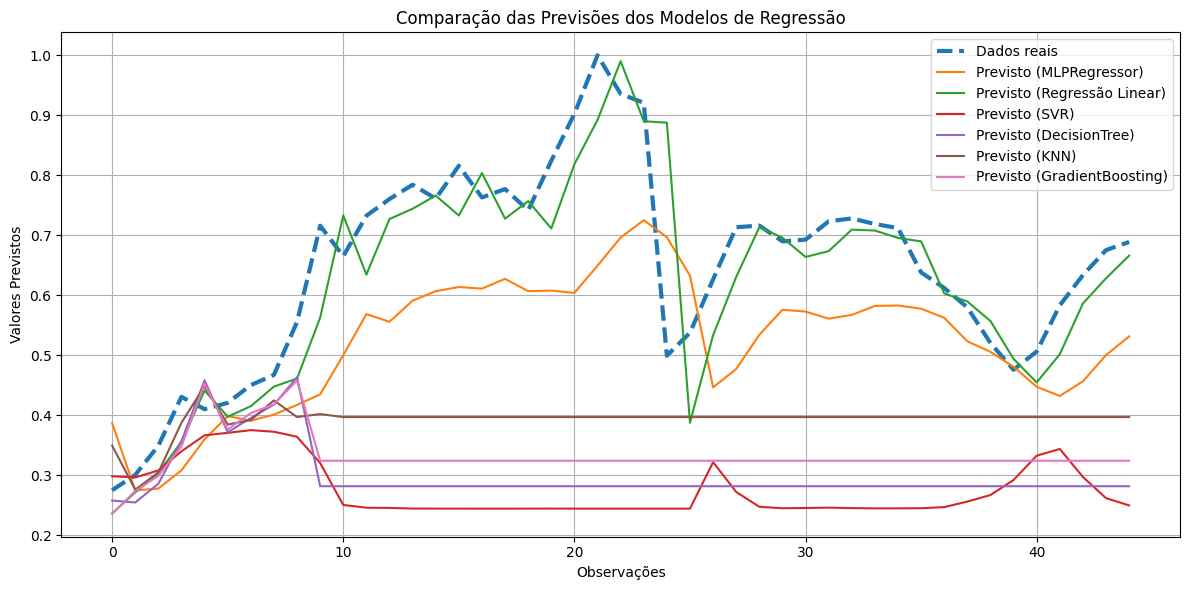

In [ ]:
#plotando os resultados sem os ajustes de ideais de hiperparametro
#comparando os modelos com os dados reais de teste(y)
plotar_previsoes(y_real=teste_y,
                 modelos_prev=[mlp_previsoes_y,
                               linear_previsoes_y,
                               svr_previsoes_y,
                               tree_previsoes_y,
                               knn_previsoes_y,
                               gboost_previsoes_y],
                 modelos_labels=['MLPRegressor',
                                 'Regressão Linear',
                                 'SVR',
                                 'DecisionTree',
                                 'KNN',
                                 'GradientBoosting']
                 )

# **6. AJUSTE DE HIPERPARÂMETROS**

1.   MLPRegressor
2.   LinearRegression
3.   SVR
4.   DecisionTreeRegressor
5.   KNeighborsRegressor
6.   GradienteBoostingRegressor

## 6.1. Importação dos Métodos de Otimização de Hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

## 6.2. Métodos de Otimização de Parâmetros

In [ ]:
# Função para otimizar os hiperparâmetros
def otimização_hiperparametros(ml_model, params, treinamento_X, treinamento_y):

    # Ajustando o GridSearchCV aos dados de treinamento
    grid_search = GridSearchCV(ml_model, params, cv=5).fit(treinamento_X, treinamento_y)


    # Apresentando os melhores hiperparâmetros encontrados
    best_params = grid_search.best_params_
    print("Melhores parâmetros encontrados:")
    print(best_params)


    return best_params

## 6.3. Otimização dos Modelos de Aprendizagem de Máquina

### MLP

In [ ]:
params_mlp = otimização_hiperparametros(MLPRegressor(max_iter=1000),
                                        params = {
                                            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                                            'activation': ['tanh', 'relu'],
                                            'solver': ['adam', 'sgd'],
                                            'learning_rate': ['constant', 'adaptive'],
                                            },
                                        treinamento_X = treinamento_X,
                                        treinamento_y = treinamento_y
                                        )

Melhores parâmetros encontrados:
{'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


### SVR

In [ ]:
params_svr = otimização_hiperparametros(SVR(),
                                        params = {
                                                'C': [0.1, 1, 10, 100],
                                                'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
                                                'epsilon': [0.01, 0.1, 1],
                                                'gamma': ['scale', 'auto']
                                                },
                                        treinamento_X = treinamento_X,
                                        treinamento_y = treinamento_y
                                        )

Melhores parâmetros encontrados:
{'C': 10, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}


### DecisionTree

In [ ]:
params_dct = otimização_hiperparametros(DecisionTreeRegressor(),
                                        params = {
                                            'max_depth': [None, 5, 10, 15],
                                            'min_samples_split': [2, 5, 10],
                                            'min_samples_leaf': [1, 2, 5],
                                            'max_features': ['sqrt', 'log2', None]
                                        },
                                        treinamento_X = treinamento_X,
                                        treinamento_y = treinamento_y
                                        )

Melhores parâmetros encontrados:
{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}


### KNN

In [ ]:
params_knn = otimização_hiperparametros(KNeighborsRegressor(),
                                        params = {
                                            'n_neighbors': [3, 5, 7, 9],
                                            'weights': ['uniform', 'distance'],
                                            'metric': ['euclidean', 'manhattan', 'minkowski'],
                                            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
                                        },
                                        treinamento_X = treinamento_X,
                                        treinamento_y = treinamento_y
                                        )

Melhores parâmetros encontrados:
{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


### GBoosting

In [ ]:
params_gboosting = otimização_hiperparametros(GradientBoostingRegressor(),
                                        params = {
                                            'n_estimators': [50, 100, 200],
                                            'learning_rate': [0.01, 0.05, 0.1],
                                            'max_depth': [3, 4, 5],
                                            'min_samples_split': [2, 3, 4],
                                            'min_samples_leaf': [1, 2, 3]
                                        },
                                        treinamento_X = treinamento_X,
                                        treinamento_y = treinamento_y
                                        )

Melhores parâmetros encontrados:
{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


# **7. RETREINANDO OS MODELOS DE APRENDIZAGEM DE MÁQUINA COM OS MELHORES PARÂMETROS**

## 7.1. Métodos de Retreinamento dos Modelos

In [ ]:
def obter_modelo_otimizado(ml_model, params, treinamento_X, treinamento_y, teste_X, teste_y):

    # Ajustando o modelo com os hiperparâmetros fornecidos
    modelo_otimizado = ml_model.set_params(**params).fit(treinamento_X, treinamento_y)

    # Realizando previsões no conjunto de teste
    previsoes_otimizado = modelo_otimizado.predict(teste_X)

    # Exibindo as métricas
    mostrar_metricas(teste_y, previsoes_otimizado)

    # Retornando o modelo ajustado
    return modelo_otimizado

### MLP

In [ ]:
mlp_otimizado = obter_modelo_otimizado(MLPRegressor(),
                                       params_mlp,
                                       treinamento_X,
                                       treinamento_y,
                                       teste_X,
                                       teste_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.0082
MAE (Erro Absoluto Médio): 0.0618
R² (Coeficiente de Determinação): 0.7017


### SVR

In [ ]:
svr_otimizado = obter_modelo_otimizado(SVR(),
                                       params_svr,
                                       treinamento_X,
                                       treinamento_y,
                                       teste_X,
                                       teste_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.0300
MAE (Erro Absoluto Médio): 0.1420
R² (Coeficiente de Determinação): -0.0975


### DecisionTree

In [ ]:
dct_otimizado = obter_modelo_otimizado(DecisionTreeRegressor(),
                                       params_dct,
                                       treinamento_X,
                                       treinamento_y,
                                       teste_X,
                                       teste_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.0795
MAE (Erro Absoluto Médio): 0.2416
R² (Coeficiente de Determinação): -1.9054


### KNN

In [ ]:
knn_otimizado = obter_modelo_otimizado(KNeighborsRegressor(),
                                       params_knn,
                                       treinamento_X,
                                       treinamento_y,
                                       teste_X,
                                       teste_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.0890
MAE (Erro Absoluto Médio): 0.2593
R² (Coeficiente de Determinação): -2.2545


### GBoosting

In [ ]:
gboosting_otimizado = obter_modelo_otimizado(GradientBoostingRegressor(),
                                       params_gboosting,
                                       treinamento_X,
                                       treinamento_y,
                                       teste_X,
                                       teste_y)

Métricas de Avaliação do Modelo:
-------------------------------
MSE (Erro Quadrático Médio): 0.1115
MAE (Erro Absoluto Médio): 0.2921
R² (Coeficiente de Determinação): -3.0774


# **8. COMPARAÇÃO VISUAL DOS RESULTADOS DO GRIDSEARCH**

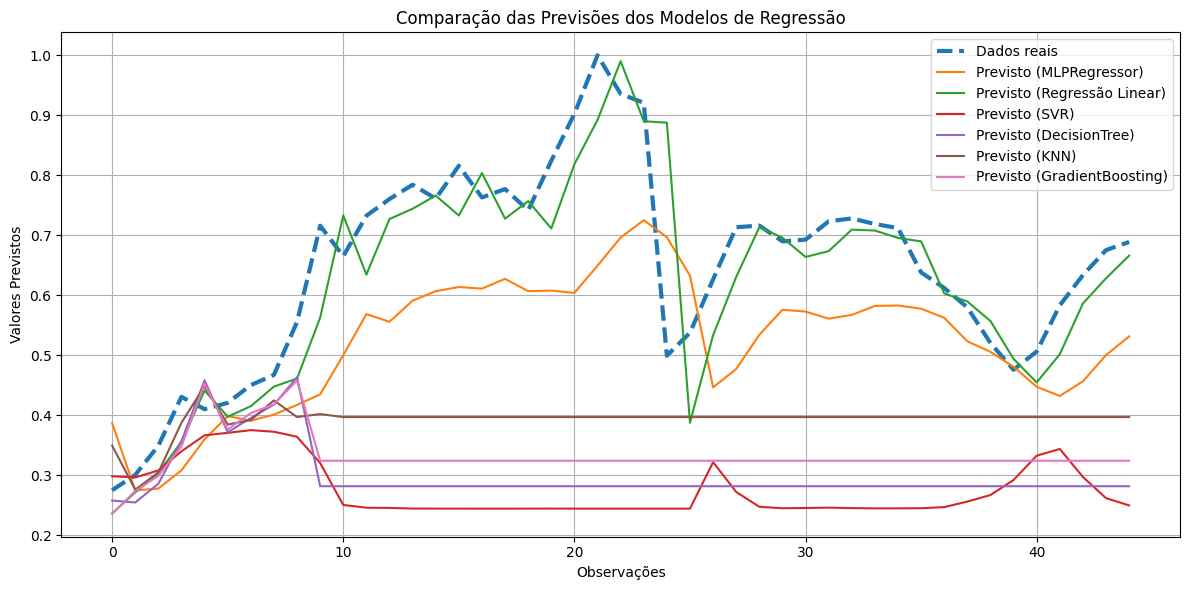

In [ ]:
#plotando os resultados sem os ajustes de ideais de hiperparametro
#comparando os modelos com os dados reais de teste(y)
plotar_previsoes(y_real=teste_y,
                 modelos_prev=[mlp_previsoes_y,
                               linear_previsoes_y,
                               svr_previsoes_y,
                               tree_previsoes_y,
                               knn_previsoes_y,
                               gboost_previsoes_y],
                 modelos_labels=['MLPRegressor',
                                 'Regressão Linear',
                                 'SVR',
                                 'DecisionTree',
                                 'KNN',
                                 'GradientBoosting']
                 )

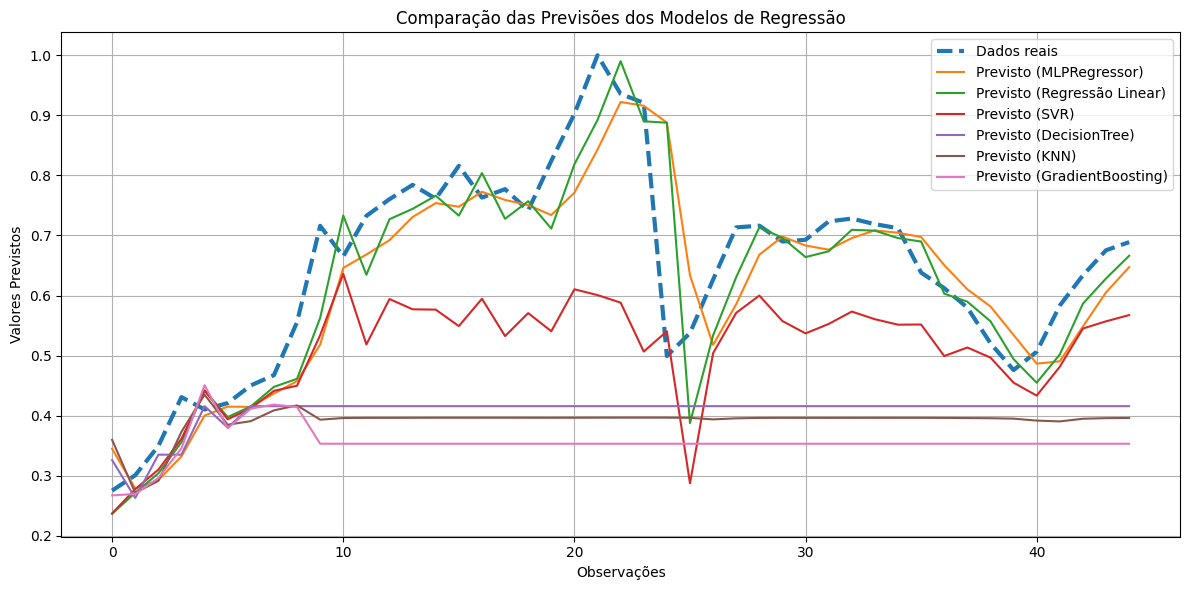

In [ ]:
#plotando os resultados sem os ajustes ideais de hiperparametro
#comparando os modelos com os dados reais de teste(y)
plotar_previsoes(y_real=teste_y,
                 modelos_prev=[mlp_otimizado.predict(teste_X),
                               linear_previsoes_y,
                               svr_otimizado.predict(teste_X),
                               dct_otimizado.predict(teste_X),
                               knn_otimizado.predict(teste_X),
                               gboosting_otimizado.predict(teste_X)],
                 modelos_labels=['MLPRegressor',
                                 'Regressão Linear',
                                 'SVR',
                                 'DecisionTree',
                                 'KNN',
                                 'GradientBoosting']
                 )